In [1]:
using SNNT
using JLD

In [2]:
using Plots
using PlotlyJS
using ColorSchemes
#pyplot()
plotlyjs()

┌ Warning: backend `PlotlyJS` is not installed.
└ @ Plots /home/samuel/.julia/packages/Plots/modjX/src/backends.jl:43


Plots.PlotlyJSBackend()

In [3]:
plot = Plots.plot
Shape = Plots.Shape

Plots.Shape

In [4]:
using PyCall

In [5]:
py"""
import numpy as np
import polytope as pc
from polytope.solvers import lpsolve
def cheby_ball(poly1):
    #logger.debug('cheby ball')
    if (poly1._chebXc is not None) and (poly1._chebR is not None):
        # In case chebyshev ball already calculated and stored
        return poly1._chebR, poly1._chebXc
    if isinstance(poly1, pc.Region):
        maxr = 0
        maxx = None
        for poly in poly1.list_poly:
            rc, xc = cheby_ball(poly)
            if rc > maxr:
                maxr = rc
                maxx = xc
        poly1._chebXc = maxx
        poly1._chebR = maxr
        return maxr, maxx
    if pc.is_empty(poly1):
        return 0, None
    # `poly1` is nonempty
    r = 0
    xc = None
    A = poly1.A
    c = np.negative(np.r_[np.zeros(np.shape(A)[1]), 1])
    norm2 = np.sqrt(np.sum(A * A, axis=1))
    G = np.c_[A, norm2]
    h = poly1.b
    sol = lpsolve(c, G, h)
    #return sol
    if sol['status'] == 0 or (sol['status'] == 4 and pc.is_inside(poly1,sol['x'][0:-1])):
        r = sol['x'][-1]
        if r < 0:
            return 0, None
        xc = sol['x'][0:-1]
    else:
        # Polytope is empty
        poly1 = pc.Polytope(fulldim=False)
        return 0, None
    poly1._chebXc = np.array(xc)
    poly1._chebR = np.double(r)
    return poly1._chebR, poly1._chebXc
"""
cheby_ball = py"cheby_ball"

PyObject <function cheby_ball at 0x7ff3f7f33280>

In [6]:
py"""
import numpy as np
import polytope as pc
def get_extremes(poly1):
    import matplotlib as mpl
    V = pc.extreme(poly1)
    rc, xc = cheby_ball(poly1)
    x = V[:, 1] - xc[1]
    y = V[:, 0] - xc[0]
    mult = np.sqrt(x**2 + y**2)
    x = x / mult
    angle = np.arccos(x)
    corr = np.ones(y.size) - 2 * (y < 0)
    angle = angle * corr
    ind = np.argsort(angle)
    return V[ind, :]
"""
get_extremes = py"get_extremes"

PyObject <function get_extremes at 0x7ff3f7f33310>

In [7]:
function poly_intersect(pc, p1, p2)
    iA = [p1.A; p2.A]
    ib = append!(p1.b,p2.b)

    return pc.Polytope(iA, ib)
end

poly_intersect (generic function with 1 method)

In [8]:
min_x1 = -400
max_x1 = 400
min_x2 = -200
max_x2 = 400

400

In [15]:
in_legend = []
unsafe_legend=false
unsafe_legend_to=false
function plot_zeppelin(star,c,w,i)
    pc = pyimport("polytope")
    if w < star.bounds[4][1] || w > star.bounds[4][2]
        return
    end
    #if star.certain
    #    print("+")
    #else
    #    print("-")
    #end
    A = star.constraint_matrix
    b = star.constraint_bias

    pc = pyimport("polytope")
    orig_poly = pc.Polytope(A[:,[1,2]],b-w*A[:,4]-(c-0.1)*A[:,3])
    bounds = pc.box2poly(collect(map(x->[x[1],x[2]],star.bounds[[1,2]])))
    p = poly_intersect(pc,orig_poly,bounds)
    #print(p)
    cheby_ball(p)
    points=[]
    try
        if pc.is_fulldim(p)
            points = get_extremes(p)
        else
            points = get_extremes(bounds)
        end
    catch
        points = get_extremes(bounds)
    end
    in_legend[i]=true
    if star.certain
        if !unsafe_legend
            plot!(Shape(convert(Vector,points[:,1]),convert(Vector,points[:,2])),label="Unsafe (certain)",fillcolor = :rosybrown1,linecolor=plot_color(:white, 0.0))
            global unsafe_legend=true
        else
            plot!(Shape(convert(Vector,points[:,1]),convert(Vector,points[:,2])),label="",fillcolor = :rosybrown1,linecolor=plot_color(:white, 0.0))
        end
    else
        if !unsafe_legend_to
            plot!(Shape(convert(Vector,points[:,1]),convert(Vector,points[:,2])),label="Unsafe (uncertain)",fillcolor = :gold,linecolor=plot_color(:white, 0.0))
            global unsafe_legend_to=true
        else
            plot!(Shape(convert(Vector,points[:,1]),convert(Vector,points[:,2])),label="",fillcolor = :gold,linecolor=plot_color(:white, 0.0))
        end
    end
end

plot_zeppelin (generic function with 1 method)

In [16]:
TIME_STEP = 0.5

MIN_WIND_SPEED = 1.0
MAX_WIND_SPEED = 30 # m/s in ~ 100 km/h
MAX_TURBULENCE = 15 # m/s in ~ 54 km/h
MAX_VELOCITY = 20 # m/s in ~ 72 km/h
function x1_min(x2, c, w)
        return -(TIME_STEP * (MAX_VELOCITY + MAX_TURBULENCE) + ((MAX_VELOCITY - MAX_TURBULENCE) / w * (c - (x2 - TIME_STEP * (MAX_TURBULENCE + MAX_VELOCITY+w))) + c) )
end

function x1_max(x2, c, w)
    return TIME_STEP * (MAX_VELOCITY + MAX_TURBULENCE) + ((MAX_VELOCITY - MAX_TURBULENCE) / w * (c - (x2 - TIME_STEP * (MAX_TURBULENCE + MAX_VELOCITY+w))) + c)
end
    
function x2_max(c,w)
    return c + w / (MAX_VELOCITY - MAX_TURBULENCE) * c + TIME_STEP * (MAX_VELOCITY + MAX_TURBULENCE + w)
end
    
function x2_min(c)
    return -c - TIME_STEP * (MAX_VELOCITY + MAX_TURBULENCE)
end

x2_min (generic function with 1 method)

In [17]:
legend_labels=false
function plot_all_zeppelin(stars,c,w;plotnew=true)
    x2_1 = x2_min(c)
    x2_2 = x2_max(c,w)
    
    x1_11 = x1_min(x2_1,c,w)
    x1_12 = x1_max(x2_1,c,w)
    x1_21 = x1_min(x2_2,c,w)
    x1_22 = x1_max(x2_2,c,w)
    
    if plotnew
        plot()
    end
    
    for (i,star) in enumerate(stars)
        plot_zeppelin(star,c,w,i)
    end
    
    polygon = [(x1_11,x2_1),(x1_12,x2_1),(x1_22,x2_2),(x1_21,x2_2),(x1_11,x2_1)]
    if !legend_labels
        plot!(map(x->x[1],polygon),map(x->x[2],polygon),linecolor=:royalblue3,label="Outer State Space Bound",margin=1Plots.mm)
    else
        plot!(map(x->x[1],polygon),map(x->x[2],polygon),linecolor=:royalblue3,label="",margin=1Plots.mm)
    end
    
    
    xtop = c + w / (MAX_VELOCITY - MAX_TURBULENCE) * c
    #min_x2 = x2_1-20
    #max_x2 = min(x2_2+20,400)
    x2 = collect(-c:1.:xtop)
    x1 = map( x -> (- ((MAX_VELOCITY - MAX_TURBULENCE) / w * (c - x) + c)), x2)
    if !legend_labels
        plot!(x1,x2, xlims=(min_x1,max_x1),ylims=(min_x2,max_x2),linecolor=:darkslategray3,label="Inner State Space Bound")
        
    else
        plot!(x1,x2, xlims=(min_x1,max_x1),ylims=(min_x2,max_x2),linecolor=:darkslategray3,label="")
    end
    plot!(Shape([0,-c,c,0],[xtop,c,c,xtop]),linecolor=:darkslategray3,fillcolor=:darkslategray3,label="")
    x22 = collect(-c:1.:xtop)
    x21 = map( x -> ( ((MAX_VELOCITY - MAX_TURBULENCE) / w * (c - x) + c)), x2)
    plot!(x21,x22, xlims=(min_x1,max_x1),ylims=(min_x2,max_x2),linecolor=:darkslategray3,label="")
    plot!([x1[1],x21[1]],[x2[1],x22[1]],linecolor=:darkslategray3,label="")
    if !legend_labels
        plot!(Shape(
                    [-c,-c,c,c,-c],
                    [c,-c,-c,c,c]),
                    label="Obstacle", fillcolor=:orange,linecolor=plot_color(:white, 0.0), xlims=(min_x1,max_x1),ylims=(min_x2,max_x2))
    else
        plot!(Shape(
                    [-c,-c,c,c,-c],
                    [c,-c,-c,c,c]),
                    label="", fillcolor=:orange,linecolor=plot_color(:white, 0.0), xlims=(min_x1,max_x1),ylims=(min_x2,max_x2))
    end
    global legend_labels=true
    return plot!()
end

plot_all_zeppelin (generic function with 1 method)

In [44]:
# ~ 2 hours
zeppelin_small2_data = load("zeppelin-1400000-8-8/result40-approx-1.jld")
#print(zeppelin_small2_data["args"])
zeppelin_small2_results = zeppelin_small2_data["result"]
zeppelin_small2_stars = zeppelin_small2_results.stars
nothing

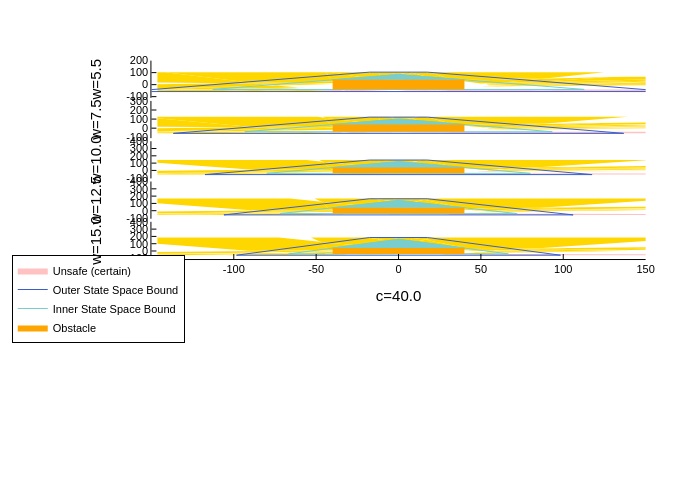

In [46]:
plots = []
legend_labels=false
unsafe_legend=false
in_legend = collect(false for star in zeppelin_small2_stars)
#print(length(in_legend))
c_vals = [5.5,7.5,10.0,12.5,15.0]
for (i,(w,x2_lim)) in enumerate(zip(c_vals,[(-110,200),(-110,300),(-110,400),(-110,400),(-110,400),(-110,400)]))
    inner_first = true
    for (c,x1_lim) in zip([40.0],[(-150,150)])
        global min_x1, max_x1 = x1_lim
        global min_x2, max_x2 = x2_lim
        push!(plots,plot_all_zeppelin(zeppelin_small2_stars,c,w))
        if inner_first
            inner_first=false
            yaxis!("w=$w",showaxis=true)
        end
        if i==length(c_vals)
            xaxis!("c=$c",showaxis=true)
        end
    end
end
#print(in_legend)
#,  legend = :outerright
fig = plot(plots...,grid=false,layout=(10,1),size = (500, 2400),link=:both,left_margin = [0Plots.mm 0Plots.mm],legend_position=:outerleft)

In [35]:
# ~ 2 hours
zeppelin_small2_data = load("zeppelin-1400000-8-8/result80-approx-1.jld")
#print(zeppelin_small2_data["args"])
zeppelin_small2_results = zeppelin_small2_data["result"]
zeppelin_small2_stars = zeppelin_small2_results.stars
nothing

Examples for concrete counterexamples:
```
# Fails: [65.7,9.0,40.0,10.0]
# Fails: [15.0,-40.2,40.0,10]
# Fails: [17.0,-41,40.0,5.5]
```

In [43]:
sum(map(x->x.filtered_out,zeppelin_small2_results.metadata))

2676

In [37]:
length(zeppelin_small2_stars)

1097

In [36]:
length(filter(x->x.certain,zeppelin_small2_stars))

256

Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

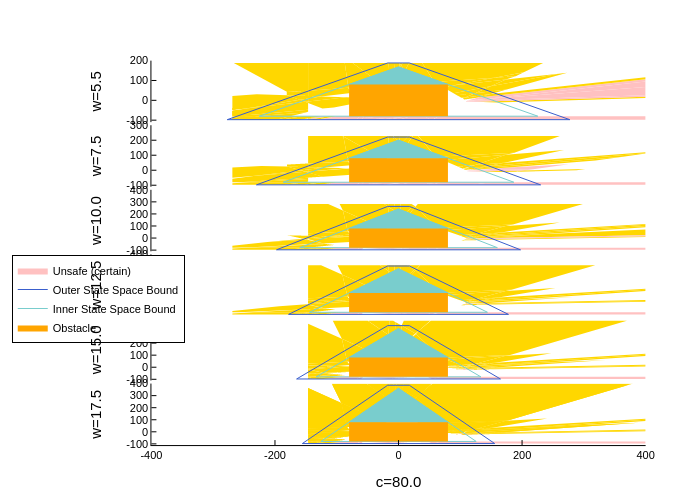

In [34]:
plots = []
legend_labels=false
unsafe_legend=false
in_legend = collect(false for star in zeppelin_small2_stars)
#print(length(in_legend))
c_vals = [5.5,7.5,10.0,12.5,15.0,17.5]
for (i,(w,x2_lim)) in enumerate(zip(c_vals,[(-110,200),(-110,300),(-110,400),(-110,400),(-110,400),(-110,400)]))
    inner_first = true
    for (c,x1_lim) in zip([80.0],[(-400,400)])
        global min_x1, max_x1 = x1_lim
        global min_x2, max_x2 = x2_lim
        push!(plots,plot_all_zeppelin(zeppelin_small2_stars,c,w))
        if inner_first
            inner_first=false
            yaxis!("w=$w",showaxis=true)
        end
        if i==length(c_vals)
            xaxis!("c=$c",showaxis=true)
        end
    end
end
print(in_legend)
#,  legend = :outerright
fig = plot(plots...,grid=false,layout=(6,1),size = (500, 2400),link=:both,left_margin = [0Plots.mm 0Plots.mm],legend_position=:outerleft)